# Audio Sentiment analysis project

In [1]:
import torch
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchaudio.backend as backend

# Check available backends
torchaudio.set_audio_backend("sox_io")


/home/tarush/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/tmp/ipykernel_4056/3171038256.py:13: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


In [2]:
datasetRAVDEES = "dataset/data/RAVDEES/"
datasetCREMAD = "dataset/data/CREMA-D/AudioWAV/"
datasetTESS = "dataset/data/TESS/TESS Toronto emotional speech set data/"

Using the naming schema to segregate our data into different emotions. We will first start with RAVDEES

RAVDESS is one of the most common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

1. Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
2. Vocal channel (01 = speech, 02 = song).
3. Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
4. Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
5. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
6. Repetition (01 = 1st repetition, 02 = 2nd repetition).
7. Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

1. Video-only (02)
2. Speech (01)
3. Fearful (06)
4. Normal intensity (01)
5. Statement "dogs" (02)
6. 1st Repetition (01)
7. 12th Actor (12) - Female (as the actor ID number is even)


                                                file    emotion
0  dataset/data/RAVDEES/Actor_21/03-01-06-01-02-0...    fearful
1  dataset/data/RAVDEES/Actor_21/03-01-04-02-02-0...        sad
2  dataset/data/RAVDEES/Actor_21/03-01-08-02-02-0...  surprised
3  dataset/data/RAVDEES/Actor_21/03-01-05-01-01-0...      angry
4  dataset/data/RAVDEES/Actor_21/03-01-07-02-01-0...    disgust


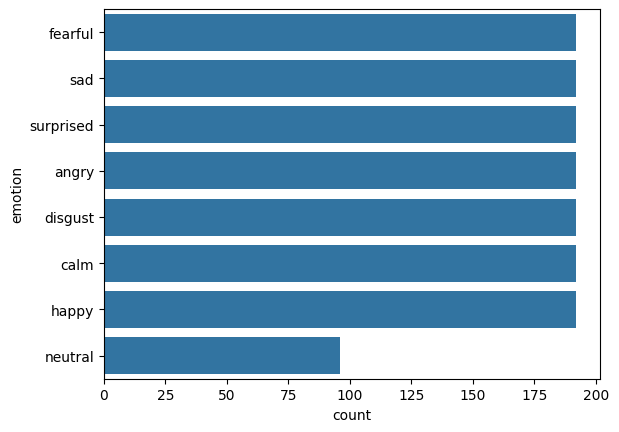

In [3]:
### We will use the naming schema for ravdees dataset and see if we can get the representing emotion for that specific audio file
def create_ravdess_dataframe(root_dir):
    # Initialize an empty list to store data
    data = []

    # Traverse through the directory structure
    for actor_dir in os.listdir(root_dir):
        actor_path = os.path.join(root_dir, actor_dir)
        if os.path.isdir(actor_path):
            for filename in os.listdir(actor_path):
                # Check if filename follows the expected format
                if filename.endswith('.wav') and filename.count('-') == 6:
                    # Extract information from the filename
                    file_info = filename.split('.')[0].split('-')
                    modality = int(file_info[0])
                    vocal_channel = int(file_info[1])
                    emotion = int(file_info[2])
                    intensity = int(file_info[3])
                    statement = int(file_info[4])
                    repetition = int(file_info[5])
                    actor_id = int(file_info[6])

                    # Determine emotion label
                    if emotion == 1:
                        emotion_label = 'neutral'
                    elif emotion == 2:
                        emotion_label = 'calm'
                    elif emotion == 3:
                        emotion_label = 'happy'
                    elif emotion == 4:
                        emotion_label = 'sad'
                    elif emotion == 5:
                        emotion_label = 'angry'
                    elif emotion == 6:
                        emotion_label = 'fearful'
                    elif emotion == 7:
                        emotion_label = 'disgust'
                    elif emotion == 8:
                        emotion_label = 'surprised'

                    # Append file path and emotion to the data list
                    file_path = os.path.join(actor_path, filename)
                    data.append((file_path, emotion_label))
                
    # Create a DataFrame object from the data list
    df = pd.DataFrame(data, columns=['file', 'emotion'])
    
    return df

### test the method
df = create_ravdess_dataframe(datasetRAVDEES)
print(df.head())
sns.countplot(df['emotion'])
plt.show()



In [4]:
### Similarly we write a method fir the CREMAD dataset and append to our df
def create_cremad_dataframe(root_dir, df):
    dirr = os.listdir(root_dir)
    for file in dirr:
        if not file.endswith('.wav'):
            continue
        nameSplit = file.split('_')
        emotion = nameSplit[2]
        if emotion == 'SAD':
            emotion = 'sad'
        elif emotion == 'ANG':
            emotion = 'angry'
        elif emotion == 'DIS':
            emotion = 'disgust'
        elif emotion == 'FEA':
            emotion = 'fearful'
        elif emotion == 'HAP':
            emotion = 'happy'
        elif emotion == 'NEU':
            emotion = 'neutral'
        elif emotion == 'SUR':
            emotion = 'surprised'
            
        # Create DataFrame for the current file
        new_df = pd.DataFrame({'file': [os.path.join(root_dir, file)], 'emotion': [emotion]})
        
        # Concatenate new DataFrame with existing DataFrame
        df = pd.concat([df, new_df], ignore_index=True)
        
    # Remove duplicate rows based on file path
    df = df.drop_duplicates(subset=['file'])
    
    return df


print(len(df))
print(df.columns)
df = create_cremad_dataframe(datasetCREMAD, df)
print(len(df))

#sorted_emotions = df['emotion'].sort_values(ascending=False).index

'''sns.countplot(df['emotion'])
plt.show()
print(df['emotion'].value_counts())'''

### now similarly we do the same for the TESS dataset


1440
Index(['file', 'emotion'], dtype='object')
8882


"sns.countplot(df['emotion'])\nplt.show()\nprint(df['emotion'].value_counts())"

8882
emotion
angry                 1863
disgust               1863
happy                 1863
fearful               1663
sad                   1663
neutral               1583
Fear                   200
Sad                    200
pleasant_surprised     200
Pleasant_surprise      200
surprised              192
calm                   192
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='emotion'>

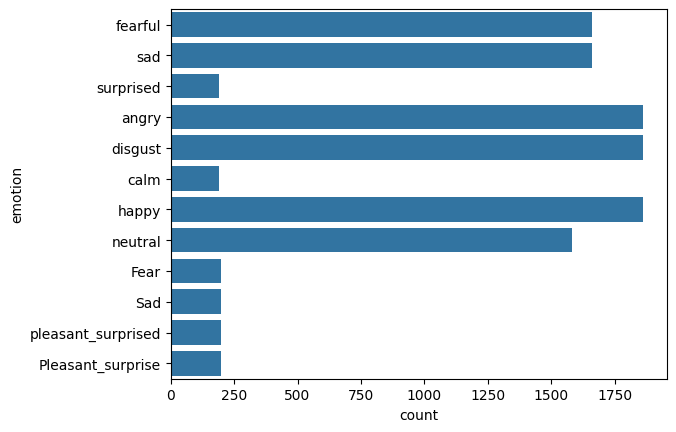

In [5]:
#### Similarly we will create the dataframe for the TESS dataset
def create_tess_dataframe(root_dir, df):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.wav'):
                # Extract emotion label from the parent directory
                emotion = os.path.basename(root)
                
                # Map emotion labels to standard emotions
                if emotion.startswith('YAF'):
                    # Remove speaker identifier for Young Female speakers
                    emotion = emotion[4:]
                elif emotion.startswith('OAF'):
                    # Remove speaker identifier for Old Female speakers
                    emotion = emotion[4:]
                elif emotion.startswith('YAF'):
                    # Remove speaker identifier for Young Male speakers
                    emotion = emotion[4:]
                elif emotion.startswith('OAF'):
                    # Remove speaker identifier for Old Male speakers
                    emotion = emotion[4:]

                # Map emotion labels to standard emotions
                if emotion == 'angry':
                    emotion = 'angry'
                elif emotion == 'disgust':
                    emotion = 'disgust'
                elif emotion == 'fear':
                    emotion = 'fearful'
                elif emotion == 'happy':
                    emotion = 'happy'
                elif emotion == 'neutral':
                    emotion = 'neutral'
                elif emotion == 'sad':
                    emotion = 'sad'
                elif emotion == 'ps':
                    emotion = 'surprised'

                # Append file path and emotion to the DataFrame
                df = pd.concat([df, pd.DataFrame({'file': [os.path.join(root, file)], 'emotion': [emotion]})], ignore_index=True)
    
    # Remove duplicate rows based on file path
    df = df.drop_duplicates(subset=['file'])
    
    return df

df_final = create_tess_dataframe(datasetTESS, df)
print(len(df))
print(df_final['emotion'].value_counts())
sns.countplot(df_final['emotion'])

8882
emotion
fearful      1863
sad          1863
angry        1863
disgust      1863
happy        1863
neutral      1775
surprised     592
Name: count, dtype: int64


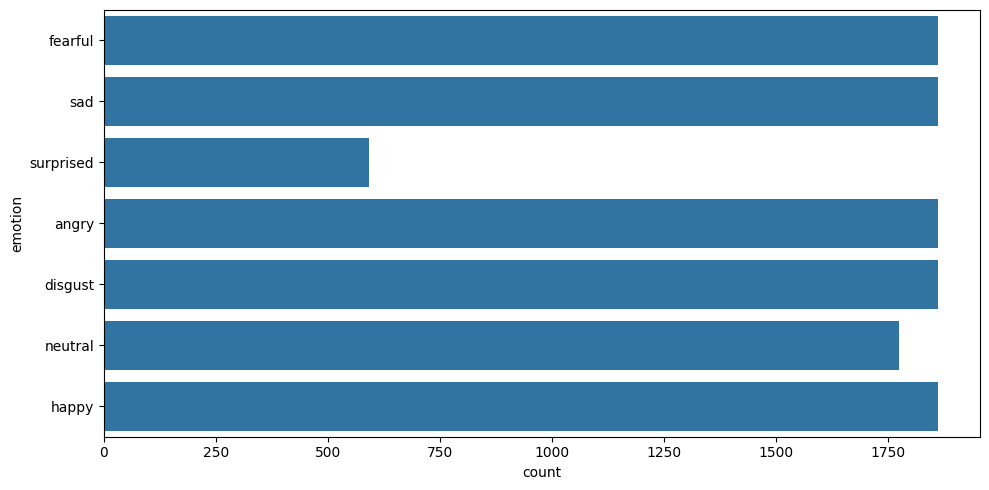

In [6]:
def combine_emotion_labels(emotion):
    if emotion.lower() in ['fear', 'fearful']:
        return 'fearful'
    elif emotion.lower() in ['sad', 'Sad']:
        return 'sad'
    elif emotion.lower() in ['pleasant_surprised', 'Pleasant_surprise', 'surprised', 'pleasant_surprise']:
        return 'surprised'
    elif emotion.lower() in ['calm']:
        return 'neutral'
    else:
        return emotion.lower()

# Apply the function to the 'emotion' column
df_final['emotion'] = df_final['emotion'].apply(combine_emotion_labels)

print(len(df))
print(df_final['emotion'].value_counts())
plt.figure(figsize=(10, 5))
sns.countplot(df_final['emotion'])
plt.tight_layout()
plt.show()

As we can see there is an imbalance of `surprise` we will be assigning class weights to help us handle the imbalance of data. We will first handle preprocessing of the audio files. We will be analysing the spectrograms and waveform and plot them in a grid. One for each emotion and we will try to figure out ways to add noise in audio. 

                                                file    emotion
0  dataset/data/RAVDEES/Actor_21/03-01-06-01-02-0...    fearful
1  dataset/data/RAVDEES/Actor_21/03-01-04-02-02-0...        sad
2  dataset/data/RAVDEES/Actor_21/03-01-08-02-02-0...  surprised
3  dataset/data/RAVDEES/Actor_21/03-01-05-01-01-0...      angry
4  dataset/data/RAVDEES/Actor_21/03-01-07-02-01-0...    disgust
5  dataset/data/RAVDEES/Actor_21/03-01-02-01-02-0...    neutral
6  dataset/data/RAVDEES/Actor_21/03-01-03-02-01-0...      happy


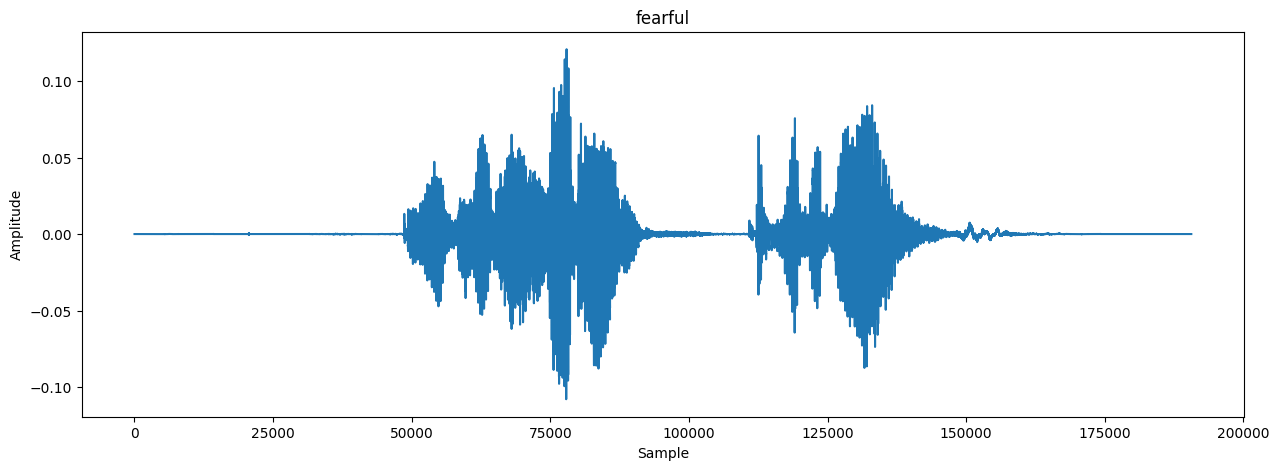

In [7]:
df_final['emotion'].unique()
data_to_plot = df_final.head(7)
print(data_to_plot)

def plot_waveform(file_path, emotion):
    waveform, sample_rate = torchaudio.load(file_path, format='wav')
    plt.figure(figsize=(15, 5))
    plt.plot(waveform.t().numpy())
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title(emotion)
    plt.show()
    
file_path = 'dataset/data/RAVDEES/Actor_21/03-01-06-01-02-01-21.wav'

# Try loading the audio file and catch any exceptions
try:
    waveform, sample_rate = torchaudio.load(file_path)
except Exception as e:
    print("Error:", e)
    
plot_waveform(data_to_plot['file'][0], data_to_plot['emotion'][0])

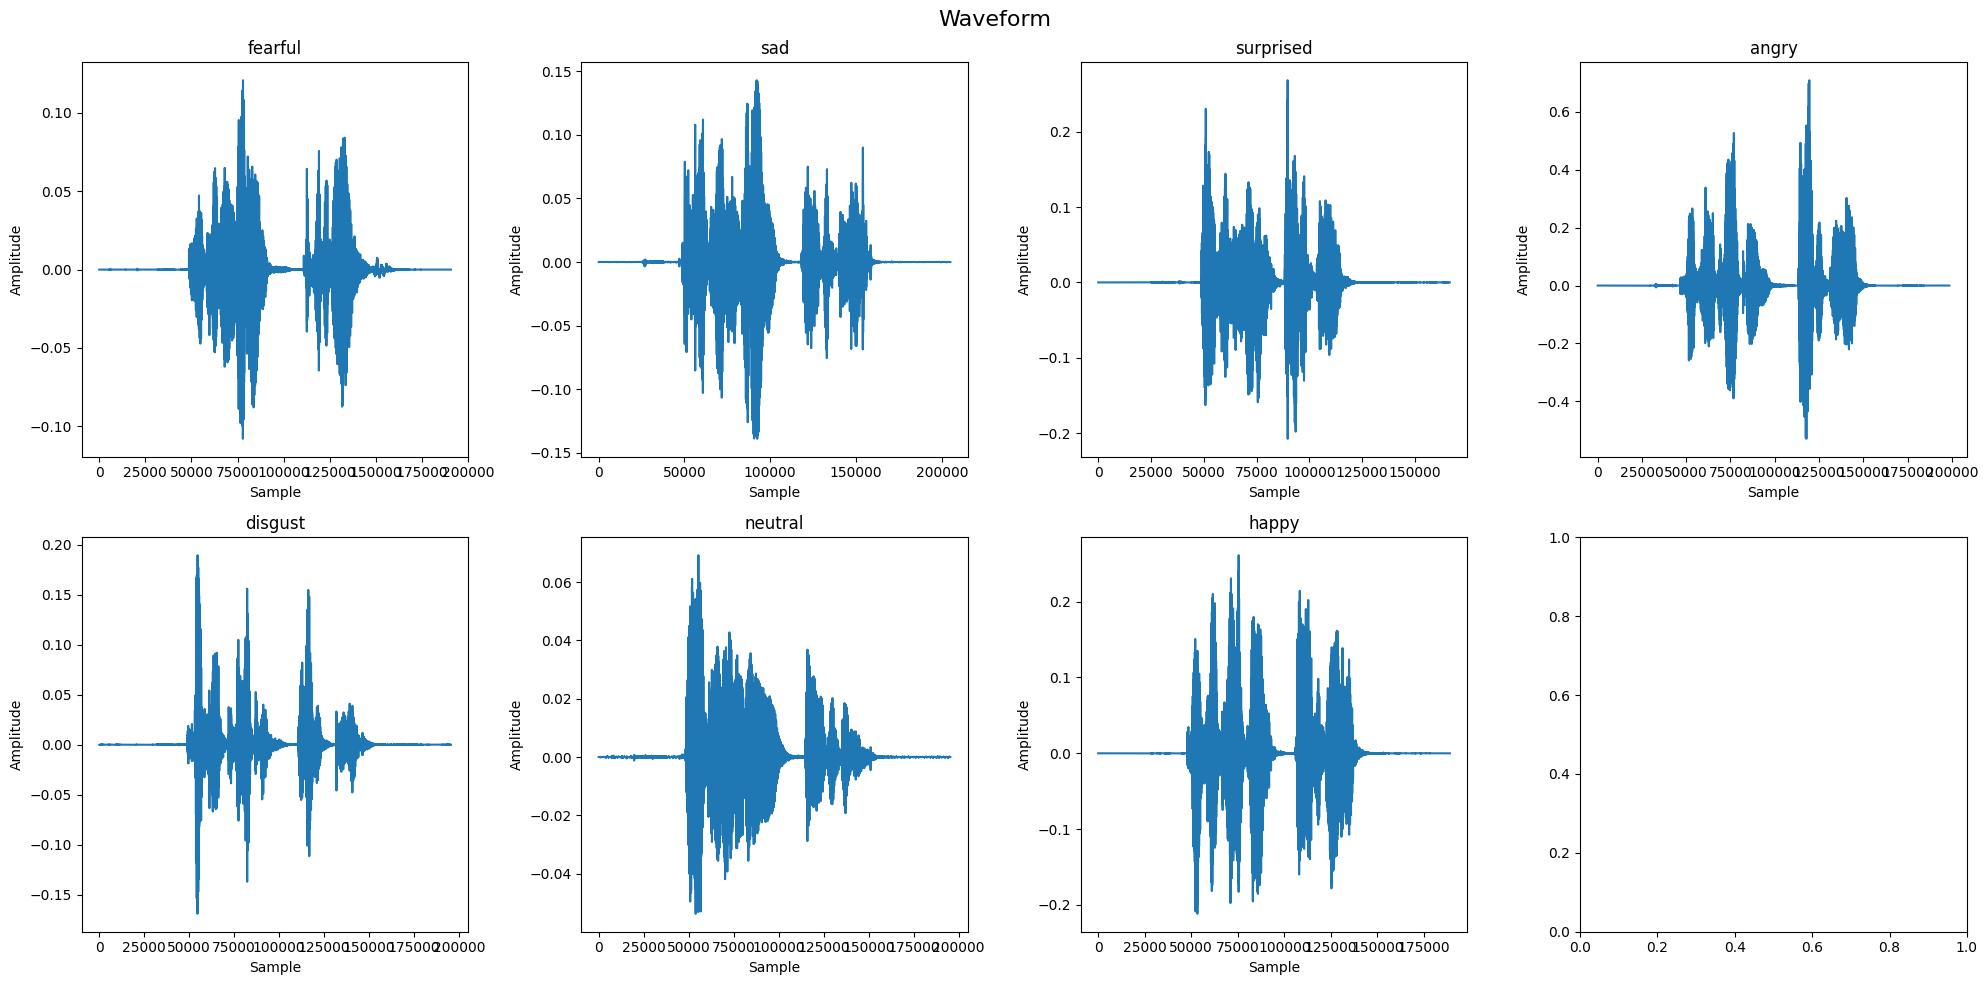

In [8]:
#### now we will be plotting the waveform for the first 7 audio files in the dataset in a grid 

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Waveform', fontsize=16)

for i in range(7):
    waveform, sample_rate = torchaudio.load(data_to_plot['file'][i])
    axs[i // 4, i % 4].plot(waveform.t().numpy())
    axs[i // 4, i % 4].set_title(data_to_plot['emotion'][i])
    axs[i // 4, i % 4].set_xlabel('Sample')
    axs[i // 4, i % 4].set_ylabel('Amplitude')
    
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

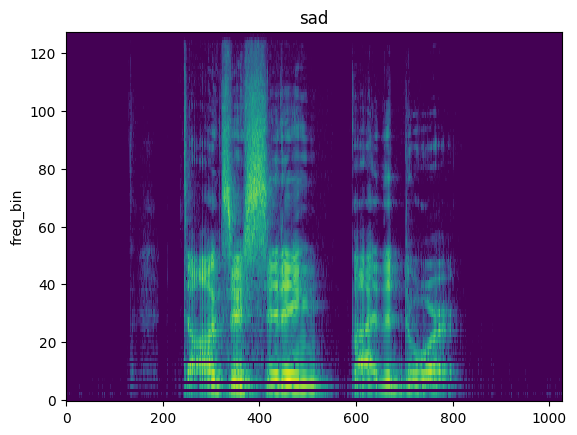

In [17]:
import librosa
def preprocess_audio_file(filepath):
    waveform, sample_rate = torchaudio.load(filepath)
    spec = torchaudio.transforms.MelSpectrogram()(waveform)
    return spec
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram[0]), origin="lower", aspect="auto", interpolation="nearest")
    
    
i = 1
specgram = preprocess_audio_file(data_to_plot['file'][i])
plt.figure(figsize=(10, 5))
plot_spectrogram(specgram, title=data_to_plot['emotion'][i])
plt.show()

### Feature extraction